In [1]:
import numpy as np
from tqdm import tqdm

from system import (
    rows,
    cols,
    states,
    s_state,
    t_state,
    wind_col,
    num_states,
    num_actions,
    init_mdp,
    init_reward,
    to_idx,
    get_valid_actions,
)
from model import Model
from policy import Policy, PolicyInit, ch_egreedy
from agent import Agent

In [2]:
def Egreedy_geneps(T: int, eps, Q_val: np.ndarray, start_state, model: Model):
        estate = [start_state]
        start_action = ch_egreedy(eps, Q_val, start_state)
        eaction = [start_action]

        for j in range(T):
            estate.append(model.gen_next(estate[-1], eaction[-1], astuple=True))
            eaction.append(ch_egreedy(eps, Q_val, estate[-1]))
            if (estate[-1] == t_state).all():
                return estate, eaction, 0 
        return estate, eaction, -1

In [3]:
mdp = init_mdp(num_states, num_actions, wind_col)
reward = init_reward(num_states, t_reward=0)

model = Model(mdp, reward)

policy = Policy(num_states, num_actions, PolicyInit.RANDOM)

agent = Agent(model, policy)

In [191]:
Q_val = np.random.uniform(-10, -1, (num_states, num_actions))
returns = [[[] for a in range(num_actions)] for s in range(num_states)]
episodic_reward = []

i = 0
T = 1000
gamma = 0.98
epsilon = 0.4
for i in tqdm(range(20000)):
    state = s_state
    estates, eactions, t_reward = Egreedy_geneps(T, epsilon, Q_val, tuple(state), model)
    T = len(estates) # Early termination

    fo = set()
    for j, (s, a) in enumerate(zip(estates, eactions)):
        if((s,a) in fo):
            continue
        fo.add((s,a))
        g = gamma*(-1*(1-gamma**(T-j-1))/(1-gamma)) + t_reward # Model specific optimization for reaching goal
        returns[to_idx(s)][a].append(g)
        Q_val[to_idx(s), a] = np.mean(returns[to_idx(s)][a])
        

    episodic_reward.append(np.max(Q_val[to_idx(s_state)][get_valid_actions(s_state)]))

100%|██████████| 20000/20000 [02:07<00:00, 156.43it/s]


In [192]:
valf = []
for s in states: 
    valid_actions = get_valid_actions(s)
    valf.append(np.max(Q_val[to_idx(s)][valid_actions]))
valf = np.array(valf)

for s in states: 
    valid_actions = get_valid_actions(s)
    action = valid_actions[np.argmax(Q_val[to_idx(s)][valid_actions])]
    policy.set_action(s, action)
agent.change_policy(policy)

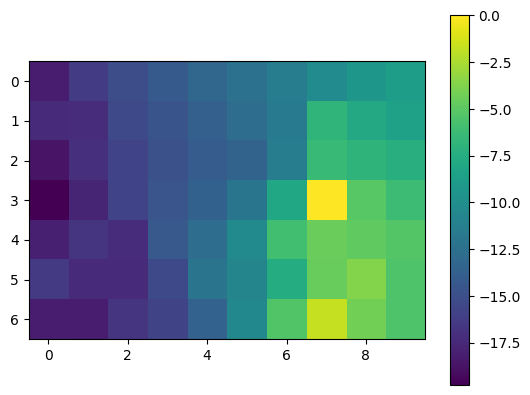

In [193]:
import matplotlib.pyplot as plt
valf_toplot = valf.reshape(rows, cols)
plt.gca().invert_yaxis()
heatmap = plt.imshow(valf_toplot)
plt.colorbar(heatmap)
plt.show()

In [194]:
print(valf[to_idx(s_state)])

-19.760007407550532


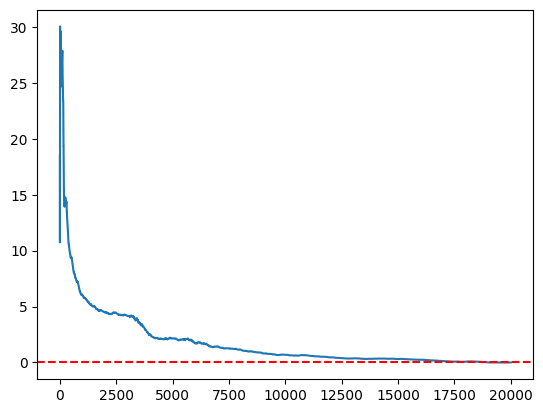

In [195]:
episodic_regret = np.abs(episodic_reward - valf[to_idx(s_state)])
plt.plot(episodic_regret)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

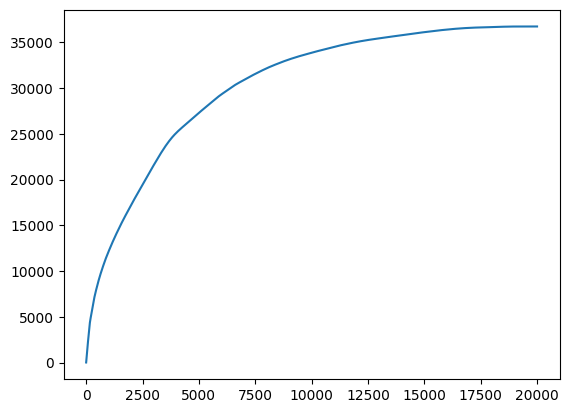

In [196]:
cummulative_regret = np.cumsum(episodic_regret)
plt.plot(cummulative_regret)
plt.show()

In [217]:
path, score = agent.play(model, policy, np.array([3,0]), 1000)

State: [3 0], Action: [-1  0], Next State: [2 0], Reward: -1
State: [2 0], Action: [0 1], Next State: [2 1], Reward: -1
State: [2 1], Action: [1 1], Next State: [3 2], Reward: -1
State: [3 2], Action: [1 1], Next State: [4 3], Reward: -1
State: [4 3], Action: [1 1], Next State: [5 4], Reward: -1
State: [5 4], Action: [1 1], Next State: [5 5], Reward: -1
State: [5 5], Action: [1 1], Next State: [3 6], Reward: -1
State: [3 6], Action: [1 1], Next State: [3 7], Reward: 0
Game Over - Score: -7


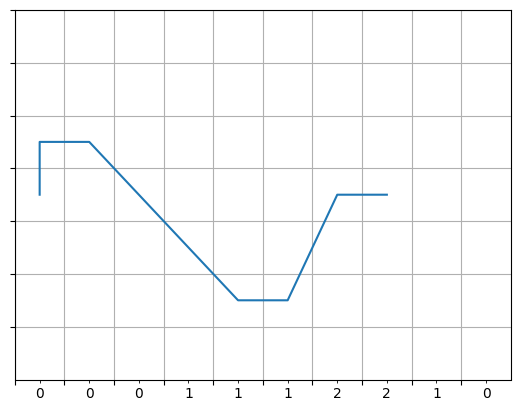

In [218]:

path_plt = np.array(path) + 0.5
y, x = path_plt.T

ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

ax.plot(x, y)
plt.show()